In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

In [4]:
import os
import sys
sys.path.append('../tools/')

from dust_extinction import calALambda
from data_binning import data_binning
import glob

In [5]:
joj_bino = np.loadtxt('./data/ZTF22aajijjf_20230314_Binospec.ascii')
joj_lris = np.loadtxt('./data/ZTF22aajijjf_20230426_LRIS.ascii')
for joj in [joj_bino, joj_lris]:
    joj[:, 1] = joj[:, 1] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))
    joj[:, 2] = joj[:, 2] * 10**(0.4 * calALambda(joj[:, 0], RV=3.1, EBV=0.04))

joj_bino_bin = data_binning(joj_bino, size=5)
joj_lris_bin = data_binning(joj_lris, size=5)

z = 0.02736
MJD_peak = 59723.65
MJD_bino = 60017.42217
MJD_lris = 60061.559493
phase_bino, phase_lris = (np.array([MJD_bino, MJD_lris]) - MJD_peak) / (1 + z) + 0.51
phase_bino, phase_lris

(286.45861586979885, 329.42050167419325)

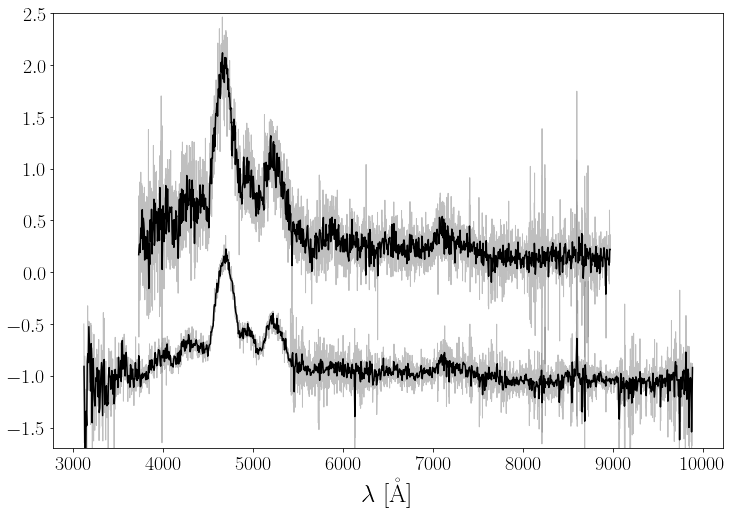

In [6]:
plt.figure(figsize=(12, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * 1.2, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * 1.2, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-1.7, 2.5)
plt.show()

# Fit line velocities

In [17]:
from absorption_line_vel import SpectrumSN_Lines

# read spec data
z = 0.02736  # redshift
Spec_bino = SpectrumSN_Lines("./data/ZTF22aajijjf_20230314_Binospec.ascii", z, bin=True, bin_size=10,)
Spec_lris = SpectrumSN_Lines("./data/ZTF22aajijjf_20230426_LRIS.ascii", z, bin=True, bin_size=10,)

## [Co iii] 6000

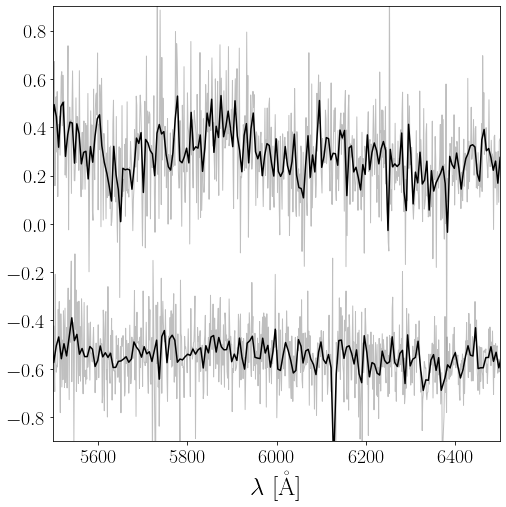

In [18]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .8, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .8, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.9, .9)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(5500, 6500)
plt.show()

binning spectrum...
LS estimation:
Velocity 1: -847 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 16 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0]  -695.399  561.394 -1228.807  -131.901     12.081    8.880   
v_sig[0]   3202.076  754.101  2376.058  3832.512     21.750   15.433   
A[0]        859.054  236.633   582.941  1050.889      6.850    4.845   
sigma_0       0.100    0.032     0.076     0.134      0.001    0.001   
EW_0       -125.901   40.753  -158.274   -80.227      1.177    0.832   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2179.099  2804.291  1.002  
v_sig[0]   1214.618  1953.179  1.003  
A[0]       1203.404  2154.447  1.002  
sigma_0    1009.640   352.590  1.004  
EW_0       1215.148  1935.665  1.002  


(-1.0, 2.1)

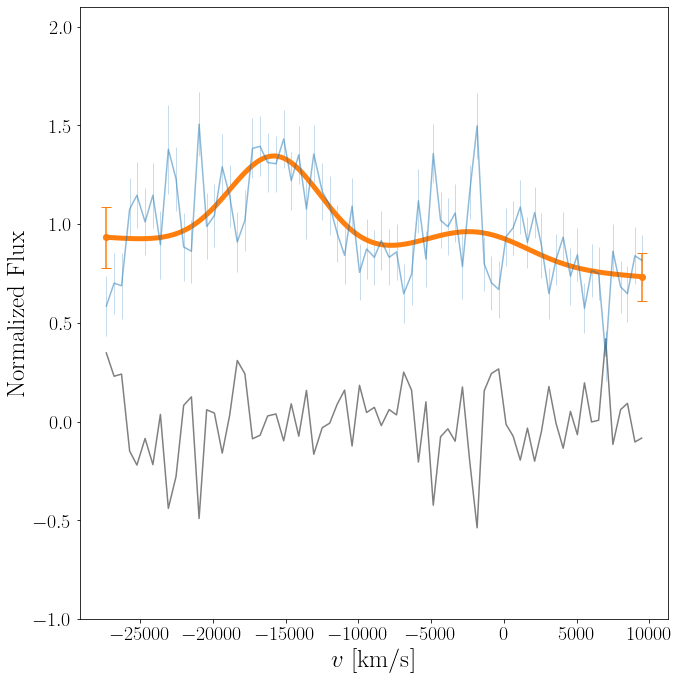

In [19]:
Spec_bino.add_line(
    "[CoIII]",
    5650,
    6400,
    lines=[[5888.48, 5906.78, 6195.45, 6127.67]],
    rel_strength=[[12.6e3, 3.82e3, 3.78e3, 2.71e3]],
)  # Table 9, Storey & Sochi 2016
Spec_bino.line["[CoIII]"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[CoIII]"].MCMC_sampler(vel_mean_mu=[0], vel_mean_sig=[1e3])
ax.set_ylim(-1, 2.1)

## [Fe ii] 7300

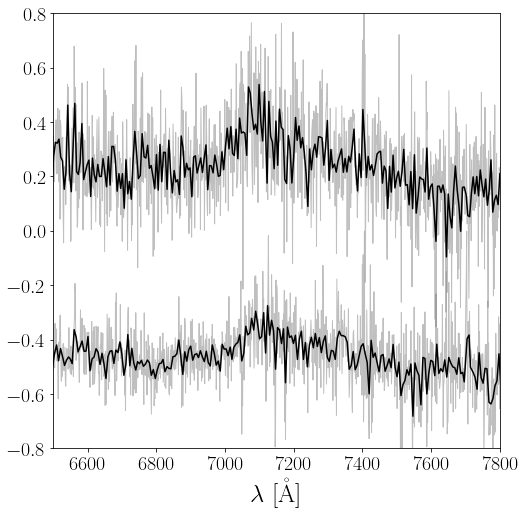

In [27]:
plt.figure(figsize=(8, 8))
for k in range(2):
    joj = [joj_bino, joj_lris][k]
    joj_bin = [joj_bino_bin, joj_lris_bin][k]
    plt.plot(joj[:, 0] / (1 + z), joj[:, 1] - k * .7, linewidth=1, color=".5", alpha=0.5)
    plt.plot(joj_bin[:, 0] / (1 + z), joj_bin[:, 1] - k * .7, color="k")
plt.xlabel(r"$\lambda\ [\mathrm{\mathring{A}}]$")
plt.ylim(-.8, .8)
# plt.axvline(6564.6, color='k')
# plt.axvline(6716.440 + 2, color='k')
plt.xlim(6500, 7800)
plt.show()

binning spectrum...
LS estimation:
Velocity 1: -2366 km/s


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 17 seconds.
The acceptance probability does not match the target. It is 0.8943, but should be close to 0.8. Try to increase the number of tuning steps.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2218.450  333.274 -2579.300 -1927.309      6.739    4.766   
v_sig[0]   3228.273  347.868  2871.849  3525.340      8.190    5.895   
A[0]       1240.668  125.805  1124.979  1368.998      2.986    2.120   
sigma_0       0.046    0.026     0.018     0.075      0.001    0.000   
EW_0       -233.908   29.077  -258.438  -203.522      0.705    0.501   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2488.815  2339.588  1.000  
v_sig[0]   1884.799  1769.282  1.002  
A[0]       1790.239  1951.939  1.002  
sigma_0    1497.714   994.847  1.001  
EW_0       1720.642  1863.076  1.002  


(-0.5, 1.6)

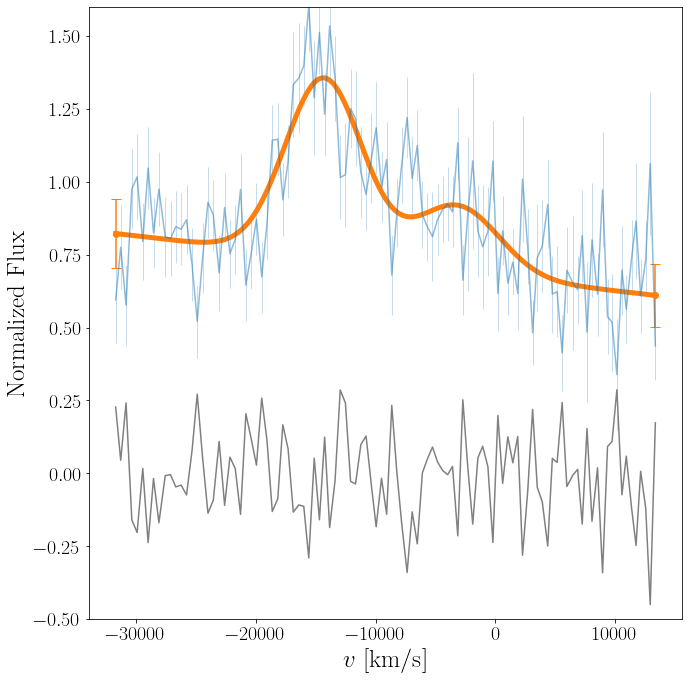

In [28]:
Spec_bino.add_line(
    "[FeII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453]],
    rel_strength=[[1, 0.24, 0.19, 0.31]],
)  # Jerkstrand et al. 2015, 2015MNRAS.448.2482J
Spec_bino.line["[FeII]_7300"].LS_estimator(guess=(1, 1, -1000, 15, 1000))
_, _, ax = Spec_bino.line["[FeII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3]
)
ax.set_ylim(-.5, 1.6)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 22 seconds.
The acceptance probability does not match the target. It is 0.6981, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8805, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8921, but should be close to 0.8. Try to increase the number of tuning steps.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -2368.188   355.463 -2736.109 -2055.849      7.591    5.369   
v_mean[1] -1101.854  1039.015 -2228.511  -209.321     19.010   14.012   
v_sig[0]   3130.605   374.368  2733.411  3442.665      8.444    5.971   
v_sig[1]   6084.485  2444.266  4645.728  9990.959     48.693   34.646   
A[0]       1200.511   155.148  1040.906  1339.851      3.840    2.750   
A[1]         85.735   245.918  -114.007   290.715      7.093    5.300   
sigma_0       0.047     0.026     0.017     0.073      0.001    0.000   
EW_0       -227.362    32.309  -255.166  -192.827      0.750    0.537   
EW_1        -12.825    35.743   -34.095    23.708      1.050    0.788   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  2219.641  2392.454  1.000  
v_mean[1]  2988.440  2808.703  1.001  
v_sig[0]   1909.335  2121.204  1.001  
v_sig[1]   2468.336  2269.408  1.000  
A[0]       1643.904  1866.844  1.001  
A[1]       1338.146  1457.329  1.00

(-0.5, 1.6)

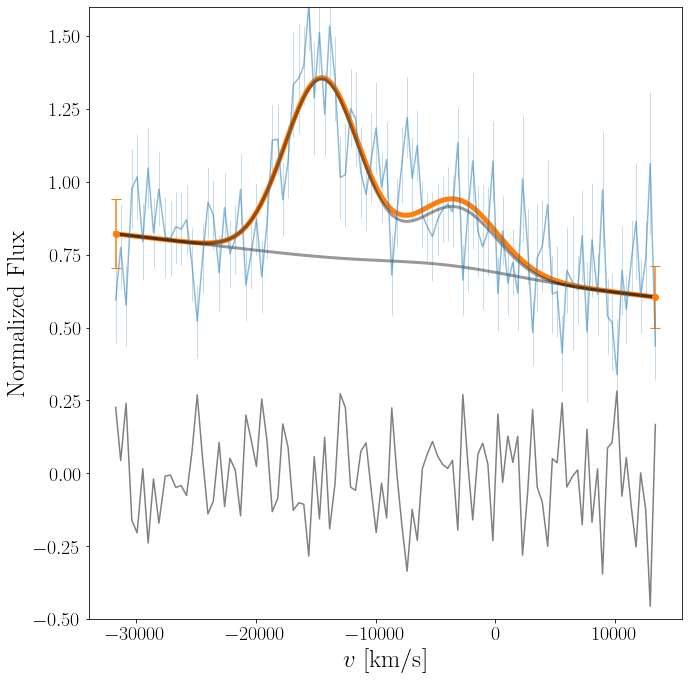

In [29]:
Spec_bino.add_line(
    "[FeII/NiII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453], [7378, 7412]],
    rel_strength=[[1, 0.24, 0.19, 0.31], [1, 0.31]],
)
_, _, ax = Spec_bino.line["[FeII/NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-2e3, -1e3],
    vel_mean_sig=[1e3, 1e3],
    vel_var_lim=[3e6, 1e8],
    initial=(1, 1, -1500, 15, 1000, -1000, 15, 1000),
    nburn=3000,
    A_lim=[-1e3, 1e4],
)
ax.set_ylim(-.5, 1.6)

(0.00549251966110747, 0.014740889774944376)

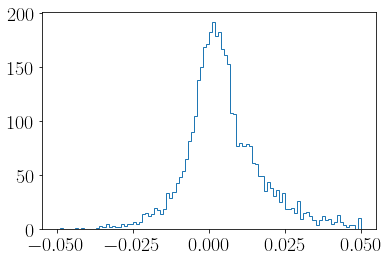

In [30]:
# tentative calculation of n(Ni ii)/n(Fe ii)
# Jerkstrand et al. 2015, 2015MNRAS.448.2482J

post = Spec_bino.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post['EW_1'].values.ravel()/post['EW_0'].values.ravel()

L_ratio = EW_ratio.ravel() / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
N = len(L_ratio)
T = np.random.rand(N) * 5000 + 3000
dc = np.random.rand(N) * 1.2 + 1.2
k_B = 8.61733326e-5
n_ratio = L_ratio / 4.9 / dc * np.exp(-0.28 / (k_B * T))
_ = plt.hist(n_ratio, histtype="step", bins=100, range=(-0.05, 0.05))
np.mean(n_ratio), np.std(n_ratio, ddof=1)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 14 seconds.


               mean       sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1242.815  421.405 -1716.610  -890.138      7.377    5.217   
v_sig[0]   4693.521  653.984  3997.823  5163.525     19.947   15.450   
A[0]       1510.375  159.700  1348.368  1640.792      4.836    3.658   
sigma_0       0.068    0.019     0.052     0.086      0.001    0.000   
EW_0       -250.621   33.440  -273.383  -213.790      1.051    0.815   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  3296.898  2748.938  1.000  
v_sig[0]   1540.277  1003.956  1.001  
A[0]       1424.005  1195.464  1.002  
sigma_0    1450.789   594.024  1.004  
EW_0       1421.255  1028.626  1.001  


(-1.0, 2.1)

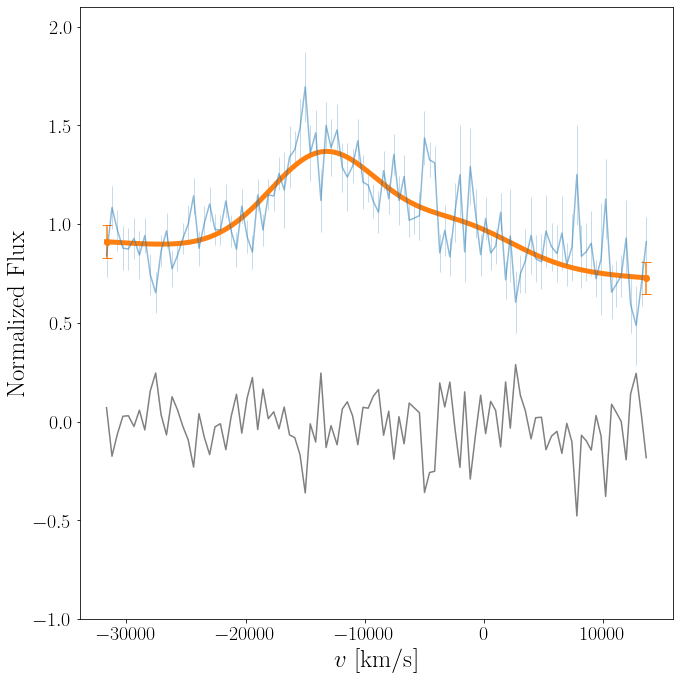

In [31]:
Spec_lris.add_line(
    "[FeII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453]],
    rel_strength=[[1, 0.24, 0.19, 0.31]],
)  # Jerkstrand et al. 2015
_, _, ax = Spec_lris.line["[FeII]_7300"].MCMC_sampler(
    vel_mean_mu=[-1e3], vel_mean_sig=[1e3], initial=(1, 1, -1000, 15, 1000)
)
ax.set_ylim(-1, 2.1)

binning spectrum...


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [blue_fl, red_fl, A, v_mean, ln_v_var, sigma_0]


Sampling 4 chains for 3_000 tune and 1_000 draw iterations (12_000 + 4_000 draws total) took 26 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.649, but should be close to 0.8. Try to increase the number of tuning steps.


               mean        sd   hdi_16%   hdi_84%  mcse_mean  mcse_sd  \
v_mean[0] -1513.489   526.015 -2046.753 -1070.576     12.567    8.887   
v_mean[1] -1272.484  1062.383 -2285.357  -206.068     23.226   19.992   
v_sig[0]   4473.682   759.393  3638.881  5027.474     20.629   14.716   
v_sig[1]   5782.806  2553.925  1738.798  7480.458     64.212   45.413   
A[0]       1442.699   241.175  1204.205  1635.346      7.202    5.366   
A[1]        103.063   306.885  -161.441   314.103      9.714    7.043   
sigma_0       0.069     0.018     0.053     0.087      0.000    0.000   
EW_0       -239.443    44.001  -267.662  -189.721      1.263    0.911   
EW_1        -13.071    38.805   -38.160    21.041      1.223    0.867   

           ess_bulk  ess_tail  r_hat  
v_mean[0]  1865.328  1455.393  1.003  
v_mean[1]  2140.310  1454.789  1.000  
v_sig[0]   1363.602  1469.317  1.003  
v_sig[1]   1461.011  1473.038  1.000  
A[0]       1198.912  1180.919  1.003  
A[1]       1092.689   684.605  1.00

(-1.0, 2.1)

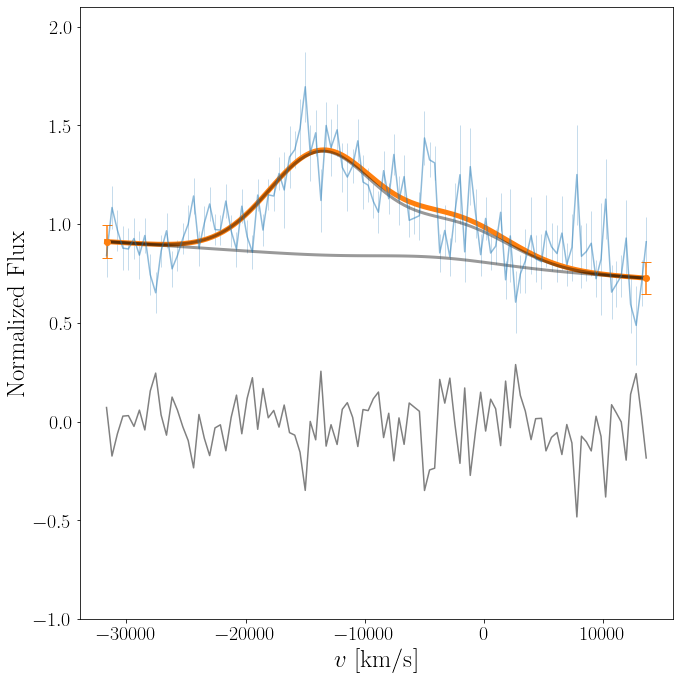

In [32]:
Spec_lris.add_line(
    "[FeII/NiII]_7300",
    6700,
    7800,
    lines=[[7155, 7172, 7388, 7453], [7378, 7412]],
    rel_strength=[[1, 0.24, 0.19, 0.31], [1, 0.31]],
)
_, _, ax = Spec_lris.line["[FeII/NiII]_7300"].MCMC_sampler(
    vel_mean_mu=[-2e3, -1e3],
    vel_mean_sig=[1e3, 1e3],
    vel_var_lim=[3e6, 1e8],
    initial=(1, 1, -1500, 15, 1000, -1000, 15, 1000),
    nburn=3000,
    A_lim=[-1e3, 1e4],
)
ax.set_ylim(-1, 2.1)

(0.006361097095757273, 0.016145460393055023)

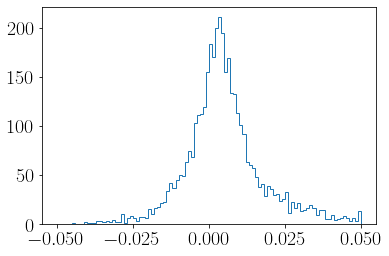

In [33]:
# tentative calculation of n(Ni ii)/n(Fe ii)
# Jerkstrand et al. 2015, 2015MNRAS.448.2482J

post = Spec_lris.line["[FeII/NiII]_7300"].trace.posterior
EW_ratio = post["EW_1"].values.ravel() / post["EW_0"].values.ravel()

L_ratio = EW_ratio.ravel() / ((1 + 0.31) / (1 + 0.24 + 0.19 + 0.31))
N = len(L_ratio)
T = np.random.rand(N) * 5000 + 3000
dc = np.random.rand(N) * 1.2 + 1.2
k_B = 8.61733326e-5
n_ratio = L_ratio / 4.9 / dc * np.exp(-0.28 / (k_B * T))
_ = plt.hist(n_ratio, histtype="step", bins=100, range=(-0.05, 0.05))
np.mean(n_ratio), np.std(n_ratio, ddof=1)